    #  Width has to b modified by cos(pi/4)

In [10]:
using PyPlot
using FileIO
using ImageMagick
using ImageIO
using Colors 
using HDF5
using Distributions
using JLD2
using FileIO
using Statistics
using StatsBase 
using LinearAlgebra
using IntervalSets
using Random
using ArraysOfArrays
using ValueShapes
using Measurements
using BenchmarkTools
using BAT 
using DSP
using SpecialFunctions
using Random123

In [11]:
include("../src/utill.jl")

plot_projections (generic function with 1 method)

In [12]:
# Pixel Size used in MCMC analysis: 
    
values_mcmc = (    
    BTV50 = [0.0271,  0.0305],
    BTV53 = [0.0216, 0.0234],
    BTV26 = [0.114, 0.125],
    IS2 = [0.0303, 0.0298], # times 3 
)

(BTV50 = [0.0271, 0.0305], BTV53 = [0.0216, 0.0234], BTV26 = [0.114, 0.125], IS2 = [0.0303, 0.0298])

## Functions: 

In [13]:
# Functions: 

function analyt_conv(x, res, start, stop) 
    return 0.5*(erf((x-start)/res/sqrt(2)) - erf((x-stop)/res/sqrt(2)))
end

function log_likelihood(parms, data)
    
    n_pixels = length(data[1,:])
    edges = range(0, step = parms.pixel_size, length = n_pixels)
    
    step_start = parms.frame_start*parms.pixel_size
    step_stop = step_start + parms.frame_width
    
    conv_run(x) = analyt_conv(x, parms.sigma_resolution * parms.pixel_size, step_start, step_stop)
    
    signal = conv_run.(edges)
    signal += parms.ped .+ parms.slope .* edges
    signal = signal .*  parms.intens
    
    ll = 0.0 
    for data_ind in 1:size(data)[1]
        data_row = data[data_ind,:]
        ll += sum(logpdf.(Normal.(signal, parms.fluct), data_row))
    end
    
    return LogDVal(ll)
end


function ll_reconstruct(parms, data)
    
    n_pixels = length(data[1,:])
    edges = range(0, step = parms.pixel_size, length = n_pixels)
    
    step_start = parms.frame_start*parms.pixel_size
    step_stop = step_start + parms.frame_width
    
    conv_run(x) = analyt_conv(x, parms.sigma_resolution * parms.pixel_size, step_start, step_stop)
    
    signal = conv_run.(edges)
    signal += parms.ped .+ parms.slope .* edges
    signal = signal .*  parms.intens
    
    return edges, signal
end


ll_reconstruct (generic function with 1 method)

In [14]:
tuning = AdaptiveMHTuning(
    λ = 0.5,
    α = ClosedInterval(0.15,0.25),
    β = 1.5,
    c = ClosedInterval(1e-4,1e2),
    r = 0.5,
)

mcmcalgo = MetropolisHastings(
    weighting = RepetitionWeighting(),
    tuning = tuning
)

rng = Philox4x()

init = MCMCChainPoolInit(
    init_tries_per_chain = 50 .. 150,
    nsteps_init = 1500
)

burnin = MCMCMultiCycleBurnin(
    max_ncycles = 160,
    nsteps_per_cycle = 40000
)

nsamples = 5*10^5
nchains = 4

convergence = BrooksGelmanConvergence(threshold=1.15);

algorithm = MCMCSampling(
        mcalg = mcmcalgo,
        trafo = NoDensityTransform(),
        nchains = nchains,
        nsteps = nsamples,
        init = init,
        burnin = burnin,
        convergence = convergence,
        strict = false,
#         store_burnin = false,
#         nonzero_weights = true,
)

MCMCSampling{MetropolisHastings{BAT.MvTDistProposal,RepetitionWeighting{Int64},AdaptiveMHTuning},NoDensityTransform,MCMCChainPoolInit,MCMCMultiCycleBurnin,BrooksGelmanConvergence,typeof(BAT.nop_func)}
  mcalg: MetropolisHastings{BAT.MvTDistProposal,RepetitionWeighting{Int64},AdaptiveMHTuning}
  trafo: NoDensityTransform NoDensityTransform()
  nchains: Int64 4
  nsteps: Int64 500000
  init: MCMCChainPoolInit
  burnin: MCMCMultiCycleBurnin
  convergence: BrooksGelmanConvergence
  strict: Bool false
  store_burnin: Bool false
  nonzero_weights: Bool true
  callback: nop_func (function of type typeof(BAT.nop_func))


# <center> Camera #1 (BTV 50) </center>

## Region 4: 

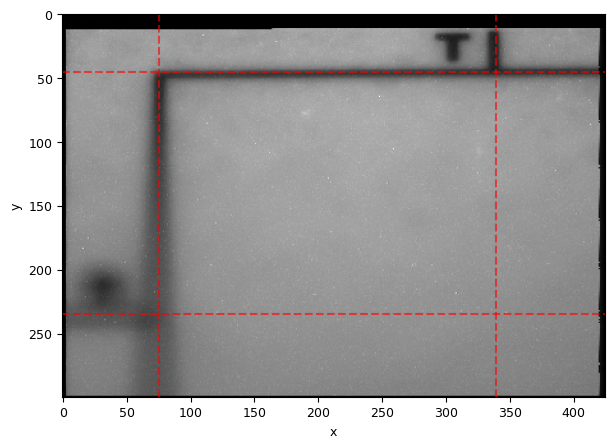

PyObject Text(23.000000000000007, 0.5, 'y')

In [157]:
img_path = "../data/resolution/2018_10_17/TT41.BTV412350_S1_F75_T.png"
img = Gray.(load(img_path))
img_y = convert(Array{Float64},img)

fig, ax = plt.subplots(1,1, figsize=(7,7))

ax.imshow(img_y, cmap="gray")

start = (x = 75, y = 235)
stop = (x = 339, y = 45)

ax.axhline(start.y, linestyle="dashed", color="red", lw=1.5, alpha=0.6)
ax.axhline(stop.y, linestyle="dashed", color="red", lw=1.5, alpha=0.6)

ax.axvline(start.x, linestyle="dashed", color="red", lw=1.5, alpha=0.6)
ax.axvline(stop.x, linestyle="dashed", color="red", lw=1.5, alpha=0.6)

ax.set_xlabel("x")
ax.set_ylabel("y")

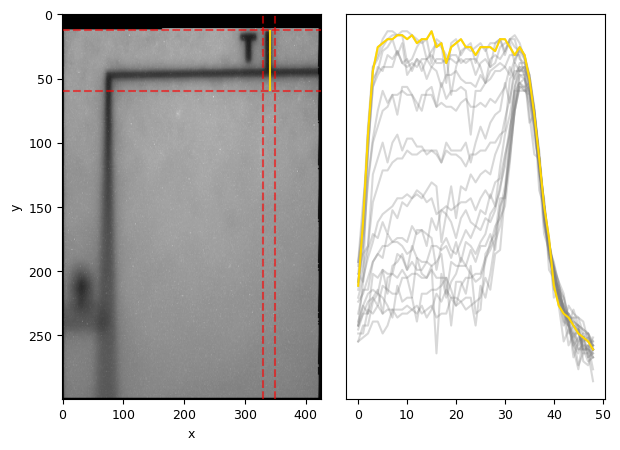

PyObject Text(23.000000000000007, 0.5, 'y')

In [158]:


pr_ind = 11 # 9:11

fig, (ax, ax2) = plt.subplots(1,2, figsize=(7,5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

ax.imshow(img_y, cmap="gray", aspect="auto")


frame = (x = [330, 350], y = [12,60])

ax.axhline(frame.y[1], linestyle="dashed", color="red", lw=1.5, alpha=0.6)
ax.axhline(frame.y[2], linestyle="dashed", color="red", lw=1.5, alpha=0.6)

ax.axvline(frame.x[1], linestyle="dashed", color="red", lw=1.5, alpha=0.6)
ax.axvline(frame.x[2], linestyle="dashed", color="red", lw=1.5, alpha=0.6)

ax.vlines(frame.x[1]+pr_ind, frame.y[1], frame.y[2], color="gold")

selected_region = img_y[frame.y[1]:frame.y[2], frame.x[1]:frame.x[2]]
selected_region = minimum(selected_region) .- selected_region
selected_region = selected_region .- minimum(selected_region)
selected_region = selected_region'

for i in eachrow(selected_region)
    ax2.plot(i, color="gray", alpha=0.3)
end

ax2.plot(selected_region[pr_ind,:], color="gold", alpha=1)
ax2.set_yticks([])

ax.set_xlabel("x")
ax.set_ylabel("y")

In [159]:
data_vector = selected_region[9:11,:]

width_tmp = ((20 - 16.97 ) / 2)*cos(pi/4)

prior = NamedTupleDist(
    frame_width = Normal(width_tmp, 0.05*width_tmp), # [mm] ticknes of the line
    pixel_size = Normal(0.0305, 0.02*0.0305), # [mm] 
    frame_start = 1 .. 35, # pixel #
    sigma_resolution = 0 .. 8, # [pixels]
    intens = 0 .. 1, # [a.u.]
    ped = -2 .. 2,
    fluct = 0.001 .. 2,
    slope = -1 .. 1,
)

log_lik(x) = log_likelihood(x, data_vector)

posterior = PosteriorDensity(log_lik, prior);

samples = bat_sample(posterior, algorithm).result;

┌ Info: Initializing new RNG of type Philox4x{UInt64,10}
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/algotypes/bat_default.jl:44
┌ Info: Using tranform algorithm DensityIdentityTransform()
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/samplers/mcmc/chain_pool_init.jl:56
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/samplers/mcmc/chain_pool_init.jl:173
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/samplers/mcmc/multi_cycle_burnin.jl:35
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/samplers/mcmc/multi_cycle_burnin.jl:65
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/samplers/mcmc/multi_cycle_burnin.jl:65
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 0 conv

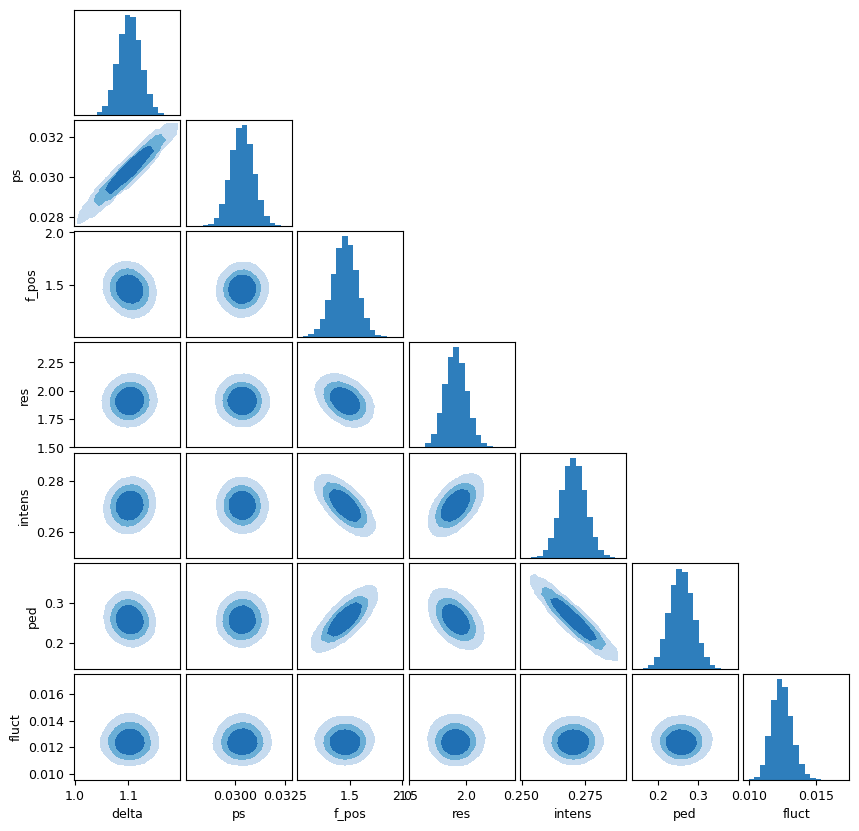

In [160]:
dims = [1,2,3,4,5,6,7,]
names = ["delta", "ps", "f_pos", "res", "intens", "ped", "fluct", "slope"]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.5, 1,]
figsize = (10,10)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [174]:
mean(samples)[1]

(frame_width = 1.1022058338873426, pixel_size = 0.030353575974056416, frame_start = 1.4542371395802949, sigma_resolution = 1.9124070370498905, intens = 0.2703540036137516, ped = 0.2580388832682723, fluct = 0.012456358806331287, slope = -0.055583552426591305)

In [219]:
1.91*0.0305

0.058254999999999994

In [218]:
0.1*0.0305

0.00305

In [173]:
std(samples)[1]

(frame_width = 0.020797933677321127, pixel_size = 0.0005636833163191373, frame_start = 0.11438887037159448, sigma_resolution = 0.09646348988457762, intens = 0.004877618447905314, ped = 0.030190297191104613, fluct = 0.0007504395379234115, slope = 0.01814247718053413)

In [171]:
sig_tmp = samples.v.pixel_size .* samples.v.sigma_resolution

mean(sig_tmp, FrequencyWeights(samples.weight)), std(sig_tmp, FrequencyWeights(samples.weight))

(0.058047578923945506, 0.003105414027992013)

In [172]:
0.0580 / 0.0271

2.1402214022140225

In [162]:
par_test = mode(samples)[1]
edges, prediction_vect = ll_reconstruct(par_test, data_vector);

In [163]:
dt_comb_1 = (dtvec=data_vector, predvec=prediction_vect)

(dtvec = [0.11372549019607842 0.16470588235294115 … 0.047058823529411764 0.03137254901960784; 0.11764705882352938 0.1764705882352941 … 0.039215686274509776 0.03137254901960784; 0.09411764705882353 0.1568627450980392 … 0.039215686274509776 0.03137254901960784], predvec = [0.1287498889362671, 0.17780678080192983, 0.23384733472223454, 0.2823652502508417, 0.31415865391573844, 0.329831171057435, 0.33549684706883465, 0.3367990497909668, 0.3367189709402659, 0.33631551147750316  …  0.12150856149524862, 0.0835932769733091, 0.06283958440005705, 0.054024298570455424, 0.05094762771888173, 0.049860579941171476, 0.04928106477890634, 0.048797827727574926, 0.048328258285378754, 0.04786014650845261])

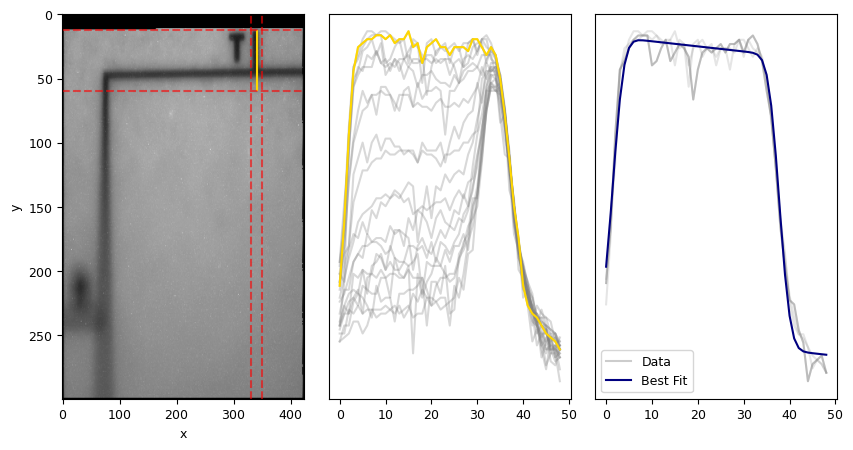

PyObject Text(23.000000000000007, 0.5, 'y')

In [164]:
fig, (ax, ax2, ax3) = plt.subplots(1,3, figsize=(10,5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

ax.imshow(img_y, cmap="gray", aspect="auto")

ax.axhline(frame.y[1], linestyle="dashed", color="red", lw=1.5, alpha=0.6)
ax.axhline(frame.y[2], linestyle="dashed", color="red", lw=1.5, alpha=0.6)

ax.axvline(frame.x[1], linestyle="dashed", color="red", lw=1.5, alpha=0.6)
ax.axvline(frame.x[2], linestyle="dashed", color="red", lw=1.5, alpha=0.6)

ax.vlines(frame.x[1]+pr_ind, frame.y[1], frame.y[2], color="gold")

for i in eachrow(selected_region)
    ax2.plot(i, color="gray", alpha=0.3)
end

for i in eachrow(data_vector)
    ax3.plot(i, color="gray", "-", alpha=0.2)
end
ax3.plot(data_vector[1,:], color="gray", "-", alpha=0.4, label="Data")
ax3.plot(prediction_vect, color="navy", label="Best Fit")
# ax3.plot(selected_region[pr_ind,:], color="gold", label="Example Data", alpha=1)
ax3.legend()

ax2.plot(selected_region[pr_ind,:], color="gold", alpha=1)
ax2.set_yticks([])
ax3.set_yticks([])

ax.set_xlabel("x")
ax.set_ylabel("y")

***

In [ ]:
# sigma x: 3.29 | 3.03 
# sigma y: 2.40 | 1.89

# <center> Camera #2 (BTV 53) <center>

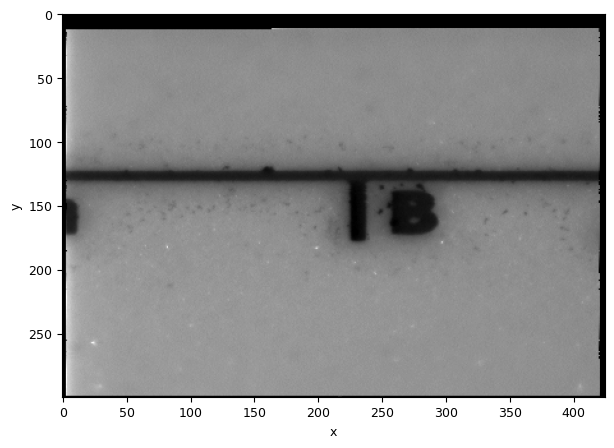

PyObject Text(23.000000000000007, 0.5, 'y')

In [178]:
img_path = "../data/resolution/2018_10_17/TT41.BTV412353_S1_F75.png"
img = Gray.(load(img_path))
img_y = convert(Array{Float64},img)

fig, ax = plt.subplots(1,1, figsize=(7,7))

ax.imshow(img_y, cmap="gray")

ax.set_xlabel("x")
ax.set_ylabel("y")

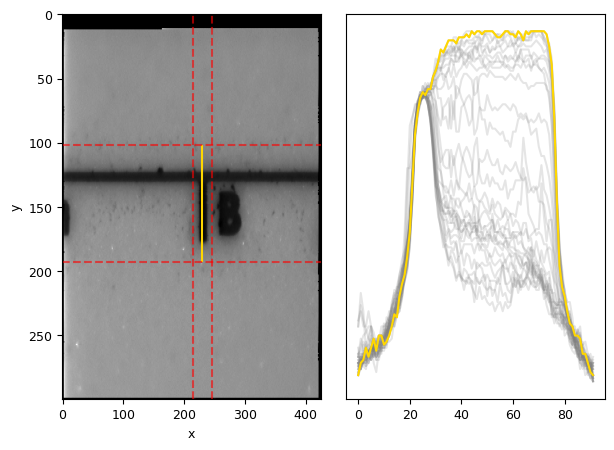

PyObject Text(23.000000000000007, 0.5, 'y')

In [179]:
frame = (x = [215, 245], y = [102,193])
fr_ind = 15
fig, (ax, ax2) = plt.subplots(1,2, figsize=(7,5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

ax.imshow(img_y, cmap="gray", aspect="auto")

ax.axhline(frame.y[1], linestyle="dashed", color="red", lw=1.5, alpha=0.6)
ax.axhline(frame.y[2], linestyle="dashed", color="red", lw=1.5, alpha=0.6)

ax.axvline(frame.x[1], linestyle="dashed", color="red", lw=1.5, alpha=0.6)
ax.axvline(frame.x[2], linestyle="dashed", color="red", lw=1.5, alpha=0.6)

ax.vlines(frame.x[1]+fr_ind, frame.y[1], frame.y[2], color="gold")

selected_region = img_y[frame.y[1]:frame.y[2], frame.x[1]:frame.x[2]]
selected_region = minimum(selected_region) .- selected_region
selected_region = selected_region .- minimum(selected_region)
selected_region = selected_region'
for i in eachrow(selected_region)
    ax2.plot(i, color="gray", alpha=0.2)
end

ax2.plot(selected_region[fr_ind,:], color="gold", alpha=1)
ax2.set_yticks([])

ax.set_xlabel("x")
ax.set_ylabel("y")

In [180]:
data_vector = selected_region[15:17,:]

width_tmp = ((20 - 16.97 ) / 2)*cos(pi/4)

prior = NamedTupleDist(
    frame_width = Normal(width_tmp, 0.05*width_tmp), # [mm] ticknes of the line
    pixel_size = Normal(0.0234, 0.02*0.0234), # [mm]
    frame_start = 2 .. 40, # pixel #
    sigma_resolution = 0 .. 15, # [pixels]
    intens = 0 .. 1, # [a.u.]
    ped = -2 .. 2,
    fluct = 0.001 .. 2,
    slope = -1 .. 1,
)

log_lik(x) = log_likelihood(x, data_vector)

posterior = PosteriorDensity(log_lik, prior);

samples = bat_sample(posterior, algorithm).result;

┌ Info: Initializing new RNG of type Philox4x{UInt64,10}
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/algotypes/bat_default.jl:44
┌ Info: Using tranform algorithm DensityIdentityTransform()
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/samplers/mcmc/chain_pool_init.jl:56
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/samplers/mcmc/chain_pool_init.jl:173
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/samplers/mcmc/multi_cycle_burnin.jl:35
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/samplers/mcmc/multi_cycle_burnin.jl:65
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/samplers/mcmc/multi_cycle_burnin.jl:65
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 0 conv

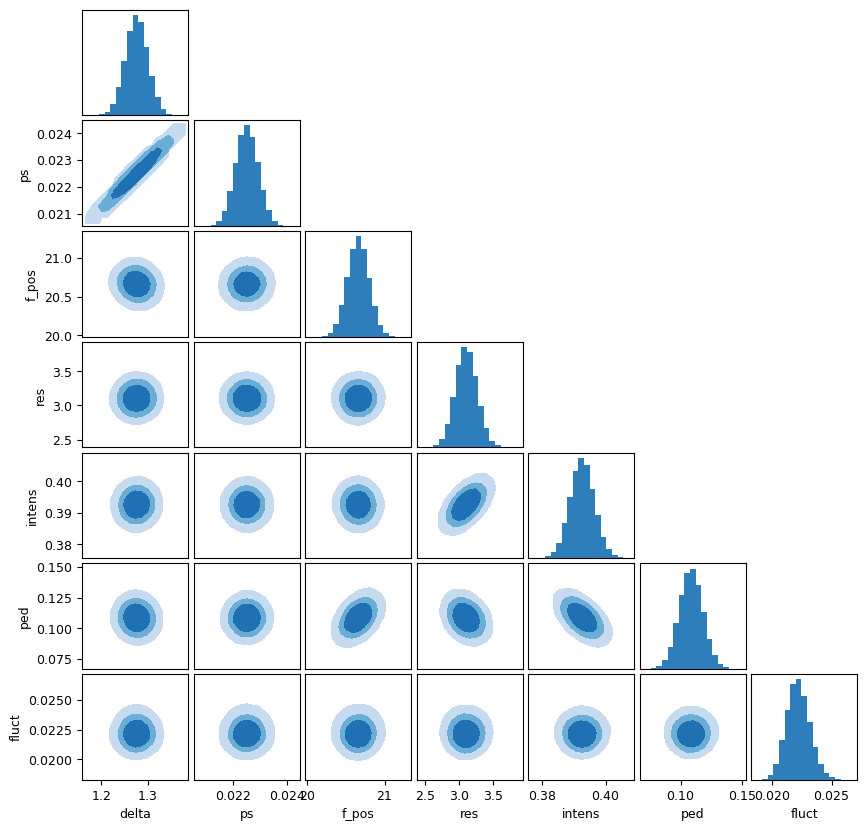

In [181]:
dims = [1,2,3,4,5,6,7,]
names = ["delta", "ps", "f_pos", "res", "intens", "ped", "fluct", "slope"]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.5, 1,]
figsize = (10,10)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [186]:
mean(samples)[1]

(frame_width = 1.276272138970789, pixel_size = 0.022517380459185322, frame_start = 20.662425502872832, sigma_resolution = 3.1066387925319754, intens = 0.3926507081225207, ped = 0.10856323530923624, fluct = 0.022220538766099213, slope = 0.008309144076012956)

In [187]:
std(samples)[1]

(frame_width = 0.02414008308914533, pixel_size = 0.00042254551241138023, frame_start = 0.1386570455578106, sigma_resolution = 0.15990505911968478, intens = 0.003796261163576977, ped = 0.00959036531306021, fluct = 0.0009628866504002614, slope = 0.007089943253045316)

In [222]:
2.11*23.4

49.373999999999995

In [221]:
0.16*23.4

3.7439999999999998

In [183]:
par_test = mode(samples)[1]
edges, prediction_vect = ll_reconstruct(par_test, data_vector);

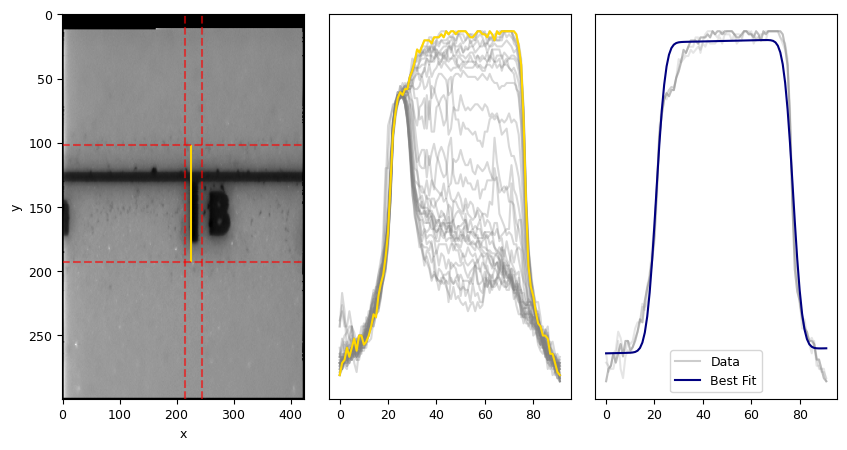

PyObject Text(23.000000000000007, 0.5, 'y')

In [184]:
fig, (ax, ax2, ax3) = plt.subplots(1,3, figsize=(10,5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

ax.imshow(img_y, cmap="gray", aspect="auto")

ax.axhline(frame.y[1], linestyle="dashed", color="red", lw=1.5, alpha=0.6)
ax.axhline(frame.y[2], linestyle="dashed", color="red", lw=1.5, alpha=0.6)

ax.axvline(frame.x[1], linestyle="dashed", color="red", lw=1.5, alpha=0.6)
ax.axvline(frame.x[2], linestyle="dashed", color="red", lw=1.5, alpha=0.6)

ax.vlines(frame.x[1]+pr_ind, frame.y[1], frame.y[2], color="gold")

for i in eachrow(selected_region)
    ax2.plot(i, color="gray", alpha=0.3)
end

for i in eachrow(data_vector)
    ax3.plot(i, color="gray", "-", alpha=0.2)
end
ax3.plot(data_vector[1,:], color="gray", "-", alpha=0.4, label="Data")
ax3.plot(prediction_vect, color="navy", label="Best Fit")
# ax3.plot(selected_region[pr_ind,:], color="gold", label="Example Data", alpha=1)
ax3.legend()

ax2.plot(selected_region[15,:], color="gold", alpha=1)
ax2.set_yticks([])
ax3.set_yticks([])

ax.set_xlabel("x")
ax.set_ylabel("y")

In [185]:
dt_comb_2 = (dtvec=data_vector, predvec=prediction_vect)

(dtvec = [0.007843137254901988 0.02352941176470591 … 0.011764705882352955 0.007843137254901988; 0.0431372549019608 0.019607843137254888 … 0.02352941176470591 0.007843137254901988; 0.03137254901960784 0.027450980392156876 … 0.019607843137254888 0.011764705882352955], predvec = [0.043141352151365456, 0.04321154818055995, 0.043281744370178, 0.043351941700483516, 0.04342214630974974, 0.043492392590879184, 0.04356285282904585, 0.04363429781480508, 0.04370980347458978, 0.04380030075012487  …  0.07347386074387022, 0.0613065748621945, 0.05467859112112845, 0.051451199412459604, 0.05006121091970978, 0.04954985631057569, 0.049411731861612476, 0.04941481021589111, 0.0494655572112804, 0.049530684368469996])

In [ ]:
# res x: 3.4229 | 3.73
# res y: 3.83 | 3.079

***

# Camera #3 (BTV 26): 

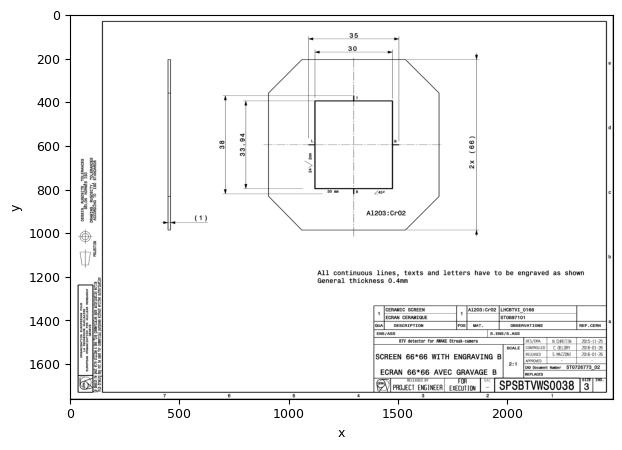

PyObject Text(23.000000000000007, 0.5, 'y')

In [190]:
img_path = "../data/resolution/Screen_BTV-26-is2.png"
img = Gray.(load(img_path))
img_frame = convert(Array{Float64},img);

fig, ax = plt.subplots(1,1, figsize=(7,7))

ax.imshow(img_frame, cmap="gray")

ax.set_xlabel("x")
ax.set_ylabel("y")

## Image 1: 

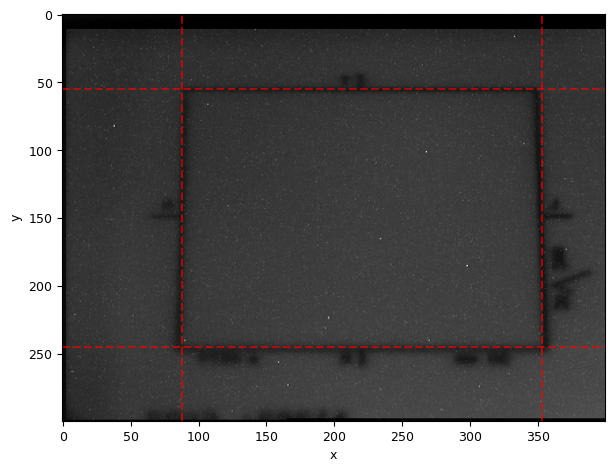

dx = 30.0 / (stop.x - start.x) = 0.11320754716981132
dy = (33.94 * cos(pi / 4)) / abs(stop.y - start.y) = 0.12631160080774434


0.12631160080774434

In [191]:
fid = h5open("../data/resolution/calib-data.h5", "r") do file
    read(file, "btv26")
    end;

img = convert.(Float64, fid)'

fig, ax = plt.subplots(1,1, figsize=(7,7))

ax.imshow(img, cmap="gray")

start = (x = 88, y = 245)
stop = (x = 353, y = 55)

ax.axhline(start.y, linestyle="dashed", color="red", lw=1.5, alpha=0.6)
ax.axhline(stop.y, linestyle="dashed", color="red", lw=1.5, alpha=0.6)

ax.axvline(start.x, linestyle="dashed", color="red", lw=1.5, alpha=0.6)
ax.axvline(stop.x, linestyle="dashed", color="red", lw=1.5, alpha=0.6)

ax.set_xlabel("x")
ax.set_ylabel("y")


@show dx = 30.0/(stop.x - start.x) # mm/pixel
@show dy = (33.94)*cos(pi/4) / abs((stop.y - start.y))

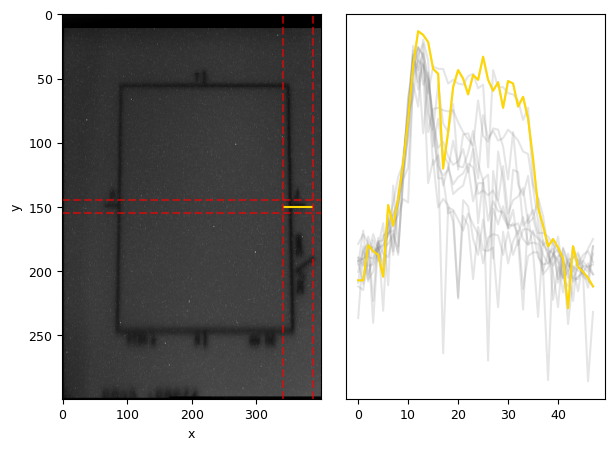

PyObject Text(23.000000000000007, 0.5, 'y')

In [192]:
frame = (x = [341, 388], y = [145,155])

tmp_ind = 5 # 5:6

fig, (ax, ax2) = plt.subplots(1,2, figsize=(7,5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

ax.imshow(img, cmap="gray", aspect="auto")

ax.axhline(frame.y[1], linestyle="dashed", color="red", lw=1.5, alpha=0.6)
ax.axhline(frame.y[2], linestyle="dashed", color="red", lw=1.5, alpha=0.6)

ax.axvline(frame.x[1], linestyle="dashed", color="red", lw=1.5, alpha=0.6)
ax.axvline(frame.x[2], linestyle="dashed", color="red", lw=1.5, alpha=0.6)

ax.hlines(frame.y[1]+tmp_ind, frame.x[1], frame.x[2], color="gold")

selected_region = img[frame.y[1]:frame.y[2], frame.x[1]:frame.x[2]]
selected_region = minimum(selected_region) .- selected_region
selected_region = selected_region .- minimum(selected_region)

for i in eachrow(selected_region)
    ax2.plot(i, color="gray", alpha=0.2)
end

ax2.plot(selected_region[tmp_ind,:], color="gold", alpha=1)
ax2.set_yticks([])

ax.set_xlabel("x")
ax.set_ylabel("y")

In [193]:
data_vector = selected_region[5:6,:]
data_vector = data_vector ./ maximum(data_vector)

fwidth = (35-30) / 2
prior = NamedTupleDist(
    frame_width = Normal(fwidth, 0.05*fwidth), # [mm] ticknes of the line
    pixel_size = Normal(0.114, 0.02*0.114), # [mm] 
    frame_start = 2 .. 20, # pixel #
    sigma_resolution = 0.0001 .. 15, # [pixels]
    intens = 0 .. 5, # [a.u.]
    ped = -2 .. 2,
    fluct = 0.001 .. 2, 
    slope = -1 .. 1,
)

log_lik(x) = log_likelihood(x, data_vector)

posterior = PosteriorDensity(log_lik, prior);

samples = bat_sample(posterior, algorithm).result;

┌ Info: Initializing new RNG of type Philox4x{UInt64,10}
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/algotypes/bat_default.jl:44
┌ Info: Using tranform algorithm DensityIdentityTransform()
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/samplers/mcmc/chain_pool_init.jl:56
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/samplers/mcmc/chain_pool_init.jl:173
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/samplers/mcmc/multi_cycle_burnin.jl:35
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/samplers/mcmc/multi_cycle_burnin.jl:65
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/samplers/mcmc/multi_cycle_burnin.jl:65
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 0 conv

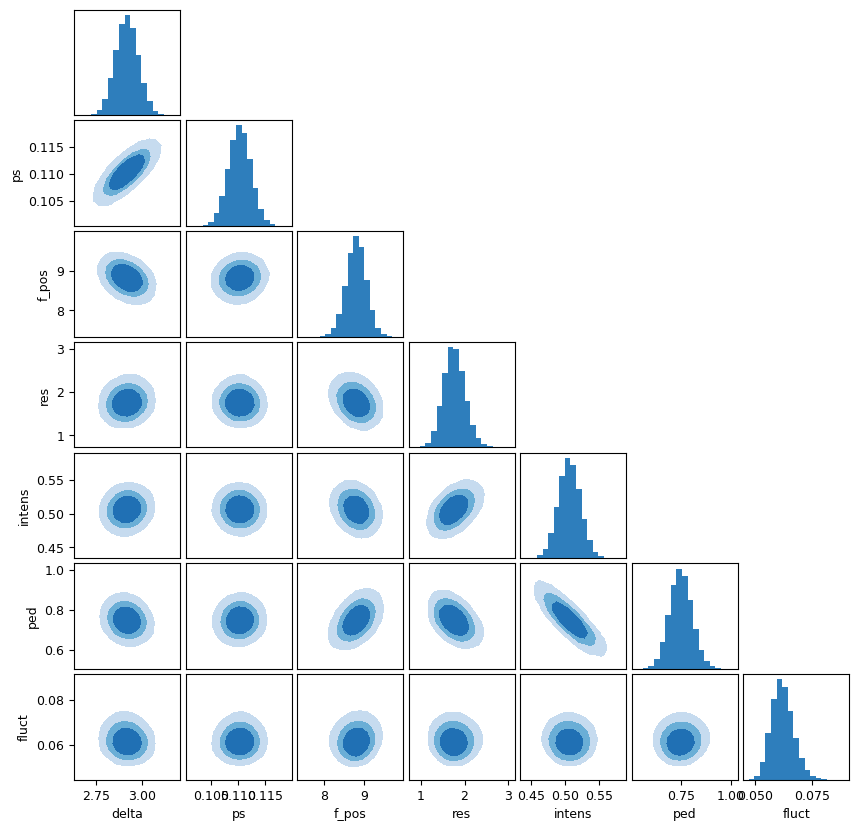

In [194]:
dims = [1,2,3,4,5,6,7,]
names = ["delta", "ps", "f_pos", "res", "intens", "ped", "fluct", "slope"]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.5, 1,]
figsize = (10,10)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [195]:
mean(samples)[1]

(frame_width = 2.9175032706338797, pixel_size = 0.11030184201988129, frame_start = 8.812127709113867, sigma_resolution = 1.7647912004072863, intens = 0.5064685086200605, ped = 0.7502085052438485, fluct = 0.06209756668770816, slope = -0.023365047770710547)

In [196]:
std(samples)[1]

(frame_width = 0.0625082681398116, pixel_size = 0.002071700943024124, frame_start = 0.24924800717937903, sigma_resolution = 0.248104255854903, intens = 0.01629261390569194, ped = 0.05629628802201126, fluct = 0.00477313088841713, slope = 0.009869957781018854)

In [223]:
1.76*114

200.64000000000001

In [224]:
0.25*114

28.5

In [197]:
par_test = mode(samples)[1]

edges, prediction_vect = ll_reconstruct(par_test, data_vector);

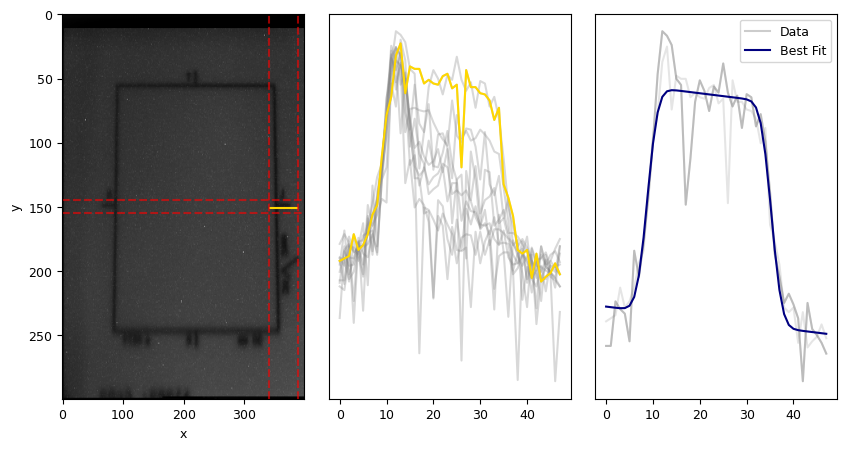

PyObject Text(23.000000000000007, 0.5, 'y')

In [198]:
fig, (ax, ax2, ax3) = plt.subplots(1,3, figsize=(10,5))

tmp_ind = 6
 
fig.subplots_adjust(hspace=0.1, wspace=0.1)

ax.imshow(img, cmap="gray", aspect="auto")

ax.axhline(frame.y[1], linestyle="dashed", color="red", lw=1.5, alpha=0.6)
ax.axhline(frame.y[2], linestyle="dashed", color="red", lw=1.5, alpha=0.6)

ax.axvline(frame.x[1], linestyle="dashed", color="red", lw=1.5, alpha=0.6)
ax.axvline(frame.x[2], linestyle="dashed", color="red", lw=1.5, alpha=0.6)

ax.hlines(frame.y[1]+tmp_ind, frame.x[1], frame.x[2], color="gold")

for i in eachrow(selected_region)
    ax2.plot(i, color="gray", alpha=0.3)
end

for i in eachrow(data_vector)
    ax3.plot(i, color="gray", "-", alpha=0.2)
end

ax3.plot(data_vector[1,:], color="gray", "-", alpha=0.4, label="Data")
ax3.plot(prediction_vect, color="navy", label="Best Fit")
# ax3.plot(selected_region[tmp_ind,:], color="gold", label="Example Data", alpha=1)
ax3.legend()

ax2.plot(selected_region[tmp_ind,:], color="gold", alpha=1)
ax2.set_yticks([])
ax3.set_yticks([])

ax.set_xlabel("x")
ax.set_ylabel("y")

In [199]:
dt_comb_3 = (dtvec=data_vector, predvec=prediction_vect)

(dtvec = [0.2881944444444444 0.2881944444444444 … 0.2951388888888889 0.2708333333333333; 0.34375 0.3506944444444444 … 0.3368055555555556 0.3055555555555556], predvec = [0.37714486267749275, 0.37583863158705905, 0.3745616603739404, 0.3735111427959221, 0.3737298039031231, 0.37906050954225173, 0.3989895243831364, 0.4476912667137528, 0.5330966252605231, 0.6425156698326153  …  0.36023553324363966, 0.33567896914958767, 0.32689675137527063, 0.32381947370880965, 0.3222024958364488, 0.3208539045076164, 0.31954101438463506, 0.31823157788661227, 0.31692238506383713, 0.3156132048039148])

## Camera #4 (IS2): (updated images)

In [203]:
using MAT

In [204]:
file = matopen("../data/resolution/is_calibr/BOVWA_02TCC4_AWAKECAM02_2020_11_02_10_58_33.mat")
img_is_1 = read(file, "data_struct") 

# img_is_1 = matread("../data/resolution/is_calibr/BOVWA_02TCC4_AWAKECAM02_2020_11_02_10_57_59.mat")
img = img_is_1["image"];

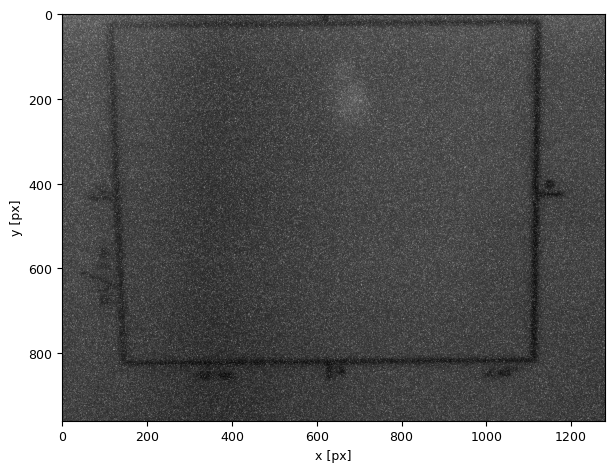

PyObject Text(23.000000000000007, 0.5, 'y [px]')

In [205]:
fig, ax = plt.subplots(1,1, figsize=(7,7))

ax.imshow(img, cmap="gray")

ax.set_xlabel("x [px]")
ax.set_ylabel("y [px]")


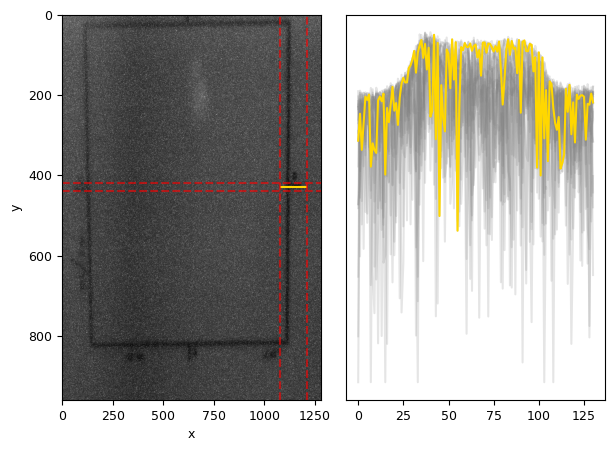

PyObject Text(23.000000000000007, 0.5, 'y')

In [206]:
frame = (x = [1080, 1210], y = [420,440])

tmp_ind = 8 # 4:8

fig, (ax, ax2) = plt.subplots(1,2, figsize=(7,5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

ax.imshow(img, cmap="gray", aspect="auto")

ax.axhline(frame.y[1], linestyle="dashed", color="red", lw=1.5, alpha=0.6)
ax.axhline(frame.y[2], linestyle="dashed", color="red", lw=1.5, alpha=0.6)

ax.axvline(frame.x[1], linestyle="dashed", color="red", lw=1.5, alpha=0.6)
ax.axvline(frame.x[2], linestyle="dashed", color="red", lw=1.5, alpha=0.6)

ax.hlines(frame.y[1]+tmp_ind, frame.x[1], frame.x[2], color="gold")

selected_region = img[frame.y[1]:frame.y[2], frame.x[1]:frame.x[2]]
selected_region = minimum(selected_region) .- selected_region
selected_region = selected_region .- minimum(selected_region)

for i in eachrow(selected_region)
    ax2.plot(i, color="gray", alpha=0.2)
end

ax2.plot(selected_region[tmp_ind,:], color="gold", alpha=1)
ax2.set_yticks([])

ax.set_xlabel("x")
ax.set_ylabel("y")

In [207]:
data_vector = [mean(selected_region[4:8,:] , dims=1)[1,:]'; mean(selected_region[8:11,:] , dims=1)[1,:]']  #selected_region[4:8,:]
data_vector = data_vector ./ maximum(data_vector)

fwidth = (45-40) / 2
prior = NamedTupleDist(
    frame_width = Normal(fwidth, 0.05*fwidth), # [mm] ticknes of the line
    pixel_size = Normal(0.0406, 0.02*0.0406), # [mm] 
    frame_start = 2 .. 50, # pixel #
    sigma_resolution = 0.0001 .. 15, # [pixels]
    intens = 0 .. 5, # [a.u.]
    ped = -2 .. 20,
    fluct = 0.001 .. 2, 
    slope = -1 .. 1,
)

log_lik(x) = log_likelihood(x, data_vector)

posterior = PosteriorDensity(log_lik, prior);

samples = bat_sample(posterior, algorithm).result;

┌ Info: Initializing new RNG of type Philox4x{UInt64,10}
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/algotypes/bat_default.jl:44
┌ Info: Using tranform algorithm DensityIdentityTransform()
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/samplers/mcmc/chain_pool_init.jl:56
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/samplers/mcmc/chain_pool_init.jl:173
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/samplers/mcmc/multi_cycle_burnin.jl:35
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/samplers/mcmc/multi_cycle_burnin.jl:65
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/samplers/mcmc/multi_cycle_burnin.jl:65
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 0 conv

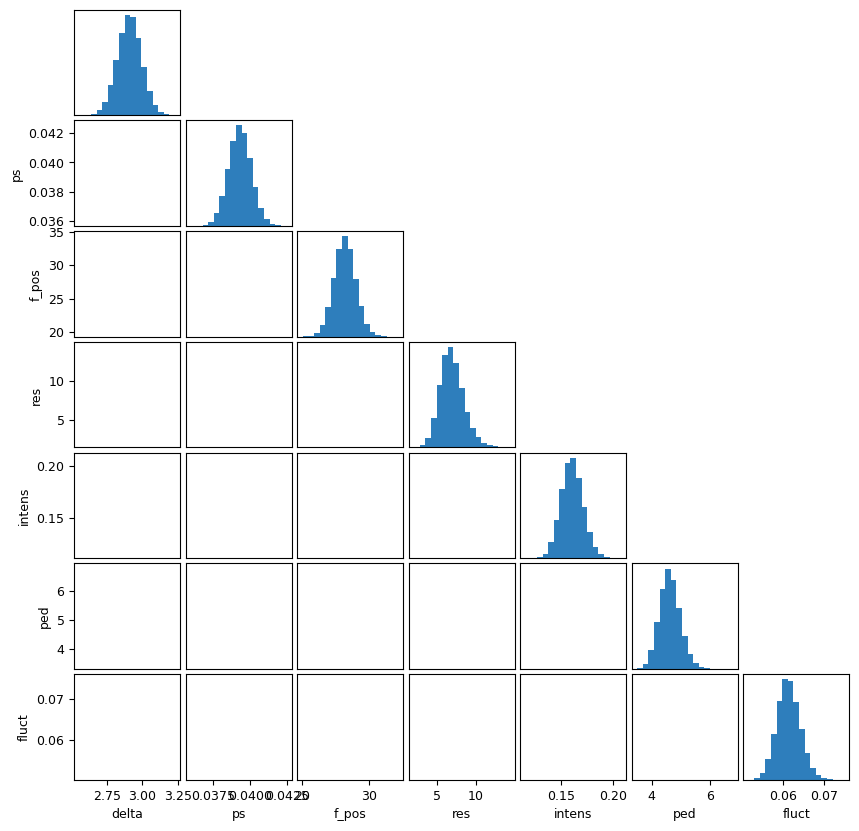

In [208]:
dims = [1,2,3,4,5,6,7,]
names = ["delta", "ps", "f_pos", "res", "intens", "ped", "fluct", "slope"]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
levels = [0.5, 1,]
figsize = (10,10)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [209]:
mean(samples)[1]

(frame_width = 2.9074295582591483, pixel_size = 0.039325249373090586, frame_start = 26.398667194160165, sigma_resolution = 6.9683709223904335, intens = 0.1606349759783761, ped = 4.624009792855763, fluct = 0.06132987462073912, slope = 0.03182614171072359)

In [210]:
std(samples)[1]

(frame_width = 0.08481715356511613, pixel_size = 0.0007711919875438081, frame_start = 1.6177215782064696, sigma_resolution = 1.5391343339819643, intens = 0.010741691339462256, ped = 0.3594826098707084, fluct = 0.002775857553166906, slope = 0.019974535256388506)

In [214]:
6.97*40.6

282.982

In [215]:
1.54*40.6

62.524

In [211]:
par_test = mode(samples)[1]

edges, prediction_vect = ll_reconstruct(par_test, data_vector);

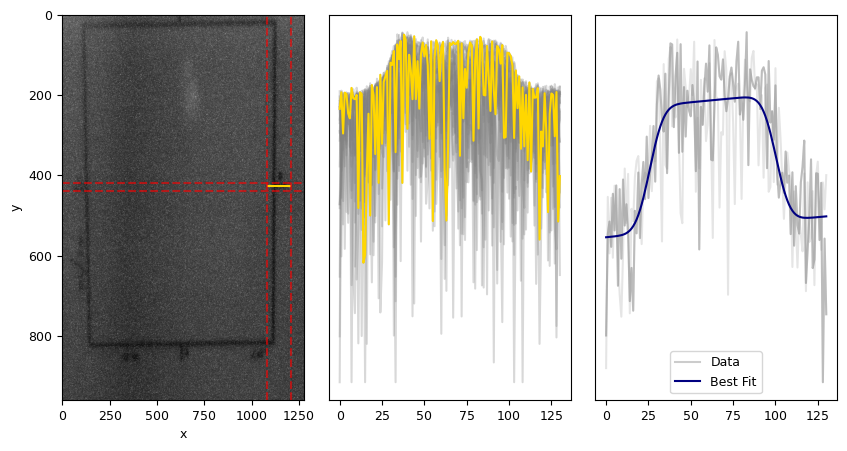

PyObject Text(23.000000000000007, 0.5, 'y')

In [212]:
fig, (ax, ax2, ax3) = plt.subplots(1,3, figsize=(10,5))

tmp_ind = 6
 
fig.subplots_adjust(hspace=0.1, wspace=0.1)

ax.imshow(img, cmap="gray", aspect="auto")

ax.axhline(frame.y[1], linestyle="dashed", color="red", lw=1.5, alpha=0.6)
ax.axhline(frame.y[2], linestyle="dashed", color="red", lw=1.5, alpha=0.6)

ax.axvline(frame.x[1], linestyle="dashed", color="red", lw=1.5, alpha=0.6)
ax.axvline(frame.x[2], linestyle="dashed", color="red", lw=1.5, alpha=0.6)

ax.hlines(frame.y[1]+tmp_ind, frame.x[1], frame.x[2], color="gold")

for i in eachrow(selected_region)
    ax2.plot(i, color="gray", alpha=0.3)
end

for i in eachrow(data_vector)
    ax3.plot(i, color="gray", "-", alpha=0.2)
end

ax3.plot(data_vector[1,:], color="gray", "-", alpha=0.4, label="Data")
ax3.plot(prediction_vect, color="navy", label="Best Fit")
# ax3.plot(selected_region[tmp_ind,:], color="gold", label="Example Data", alpha=1)
ax3.legend()

ax2.plot(selected_region[tmp_ind,:], color="gold", alpha=1)
ax2.set_yticks([])
ax3.set_yticks([])

ax.set_xlabel("x")
ax.set_ylabel("y")

In [213]:
dt_comb_4 = (dtvec=data_vector, predvec=prediction_vect)

(dtvec = [0.6106662479719475 0.7406186214476369 … 0.7350185795781651 0.6378290678808813; 0.5687051865808342 0.7885853352174595 … 0.7725571779975925 0.8164547024650651], predvec = [0.7367218437364016, 0.7369338335635013, 0.7371501784772392, 0.7373739127278081, 0.7376098714080874, 0.7378655450914453, 0.7381522094464158, 0.7384863460785444, 0.738891329294055, 0.7393992906471409  …  0.7618258569986076, 0.761979990074513, 0.7621550135860601, 0.7623430317802304, 0.7625389298549219, 0.7627394867919753, 0.7629427297444321, 0.7631474829871551, 0.7633530645238453, 0.7635590891835893])

# Summary: 

In [118]:
# Resolution: 

cam_1 = (x = 2.0, y = 2.0, σx = 1.0, σy = 1.0)
cam_2 = (x = 3.0, y = 3.0, σx = 1.0, σy = 1.0)
cam_3 = (x = 2.0, y = 2.0, σx = 1.0, σy = 1.0) 
cam_4 = (x = 6.5, y = 6.5, σx = 2.0, σy = 2.0)

(x = 6.5, y = 6.5, σx = 2.0, σy = 2.0)

In [153]:
img_path = "../data/resolution/2018_10_17/TT41.BTV412350_S1_F75_T.png"
img = Gray.(load(img_path))
img_1 = convert(Array{Float64},img)

img_path = "../data/resolution/2018_10_17/TT41.BTV412353_S1_F75.png"
img = Gray.(load(img_path))
img_2 = convert(Array{Float64},img)

fid = h5open("../data/resolution/calib-data.h5", "r") do file
    read(file, "btv26")
    end;
img_3 = convert.(Float64, fid)'

file = matopen("../data/resolution/is_calibr/BOVWA_02TCC4_AWAKECAM02_2020_11_02_10_58_33.mat")
img_is_1 = read(file, "data_struct") 
img_4 = img_is_1["image"];

In [154]:
SMALL_SIZE = 9
MEDIUM_SIZE = 9
BIGGER_SIZE = 10

plt.rc("font", size=SMALL_SIZE)          # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc("axes", labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)    # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

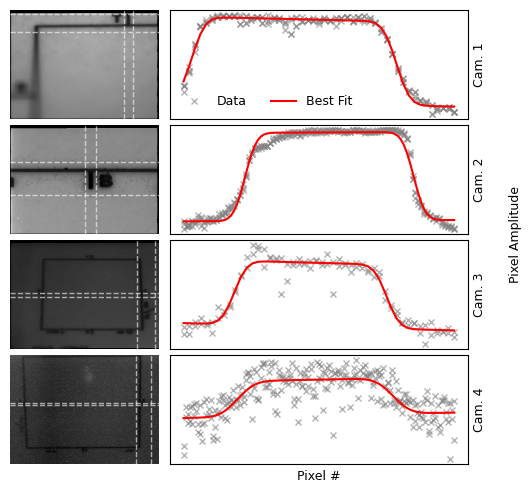

In [156]:
fig, ax = plt.subplots(4,2, figsize=(5.905631659056317, 5.905631659056317), gridspec_kw=Dict("width_ratios"=> [1,2]))

fig.subplots_adjust(hspace=0.05, wspace=0.05)

ax[1,1].pcolormesh(img_1, cmap="gray", shading="gouraud") #shading="gouraud"
ax[2,1].pcolormesh(img_2, cmap="gray", shading="gouraud")
ax[3,1].pcolormesh(img_3, cmap="gray", shading="gouraud")
ax[4,1].pcolormesh(img_4, cmap="gray", shading="gouraud")

ax[1,1].invert_yaxis()
ax[2,1].invert_yaxis()
ax[3,1].invert_yaxis()
ax[4,1].invert_yaxis()

ax[1,1].set_axis_off()
ax[2,1].set_axis_off()
ax[3,1].set_axis_off()
ax[4,1].set_axis_off()

ax[1,2].set_yticks([])
ax[2,2].set_yticks([])
ax[3,2].set_yticks([])
ax[4,2].set_yticks([])

ax[1,2].set_xticks([])
ax[2,2].set_xticks([])
ax[3,2].set_xticks([])
ax[4,2].set_xticks([])


frame = (x = [325, 350], y = [12,60])
ax[1,1].axhline(frame.y[1], linestyle="dashed", color="white", lw=1.0, alpha=0.6)
ax[1,1].axhline(frame.y[2], linestyle="dashed", color="white", lw=1.0, alpha=0.6)
ax[1,1].axvline(frame.x[1], linestyle="dashed", color="white", lw=1.0, alpha=0.6)
ax[1,1].axvline(frame.x[2], linestyle="dashed", color="white", lw=1.0, alpha=0.6)

frame = (x = [215, 245], y = [102,193])
ax[2,1].axhline(frame.y[1], linestyle="dashed", color="white", lw=1.0, alpha=0.6)
ax[2,1].axhline(frame.y[2], linestyle="dashed", color="white", lw=1.0, alpha=0.6)
ax[2,1].axvline(frame.x[1], linestyle="dashed", color="white", lw=1.0, alpha=0.6)
ax[2,1].axvline(frame.x[2], linestyle="dashed", color="white", lw=1.0, alpha=0.6)

frame = (x = [341, 388], y = [145,155])
ax[3,1].axhline(frame.y[1], linestyle="dashed", color="white", lw=1.0, alpha=0.6)
ax[3,1].axhline(frame.y[2], linestyle="dashed", color="white", lw=1.0, alpha=0.6)
ax[3,1].axvline(frame.x[1], linestyle="dashed", color="white", lw=1.0, alpha=0.6)
ax[3,1].axvline(frame.x[2], linestyle="dashed", color="white", lw=1.0, alpha=0.6)

frame = (x = [1080, 1210], y = [420,440])
ax[4,1].axhline(frame.y[1], linestyle="dashed", color="white", lw=1.0, alpha=0.6)
ax[4,1].axhline(frame.y[2], linestyle="dashed", color="white", lw=1.0, alpha=0.6)
ax[4,1].axvline(frame.x[1], linestyle="dashed", color="white", lw=1.0, alpha=0.6)
ax[4,1].axvline(frame.x[2], linestyle="dashed", color="white", lw=1.0, alpha=0.6)

for i in eachrow(dt_comb_1.dtvec)
    ax[1,2].plot(i, color="gray", "x", ms=4, alpha=0.6)
end
ax[1,2].plot(dt_comb_1.dtvec[1,:], color="gray", "x", ms=4, alpha=0.6, label="Data")


for i in eachrow(dt_comb_2.dtvec)
    ax[2,2].plot(i, color="gray", "x", ms=4, alpha=0.6)
end

for i in eachrow(dt_comb_3.dtvec)
    ax[3,2].plot(i, color="gray", "x", ms=4, alpha=0.6)
end

for i in eachrow(dt_comb_4.dtvec)
    ax[4,2].plot(i, color="gray", "x", ms=4, alpha=0.6)
end

ax[1,2].plot(dt_comb_1.predvec, color="red", label="Best Fit")
ax[2,2].plot(dt_comb_2.predvec, color="red", label="Best Fit")
ax[3,2].plot(dt_comb_3.predvec, color="red", label="Best Fit")
ax[4,2].plot(dt_comb_4.predvec, color="red", label="Best Fit")

ax[1,2].legend(ncol=2, loc="lower left", framealpha=0.0)

ax[4,2].set_xlabel("Pixel #")
ax[4,2].set_ylabel("Cam. 4")
ax[3,2].set_ylabel("Cam. 3")
ax[2,2].set_ylabel("Cam. 2")
ax[1,2].set_ylabel("Cam. 1")
ax[4,2].yaxis.set_label_position("right")
ax[4,2].yaxis.tick_right()
ax[3,2].yaxis.set_label_position("right")
ax[3,2].yaxis.tick_right()
ax[2,2].yaxis.set_label_position("right")
ax[2,2].yaxis.tick_right()
ax[1,2].yaxis.set_label_position("right")
ax[1,2].yaxis.tick_right()

fig.text(0.97, 0.5, "Pixel Amplitude", va="center", rotation="vertical")

fig.savefig("../plots/resolution-example.png", bbox_inches = "tight")